# STORM

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density. 

The control flow looks like the diagram below.

![STORM diagram](./img/storm.png)

STORM имеет несколько основных этапов:

1. Создание первоначальной структуры + Обзор связанных предметов
2. Определение различных точек зрения
3. "Интервью с экспертами по предмету" (ролевые игры LLM)
4. Уточнение структуры (используя ссылки)
5. Написание разделов, затем написание статьи

Этап интервью с экспертами происходит между ролевым автором статьи и исследовательским экспертом. "Эксперт" может запрашивать внешние знания и отвечать на конкретные вопросы, сохраняя цитируемые источники в векторном хранилище, так что на более поздних этапах уточнения можно синтезировать полную статью.

Есть несколько гиперпараметров, которые вы можете установить для ограничения (потенциально) бесконечной ширины исследований:

N: Количество перспектив для обзора / использования (Шаги 2->3)
M: Максимальное количество ходов разговора на этапе (Шаг 3)


## Prerequisites

In [1]:
# %pip install -U gigachain_community gigachain_openai langgraph wikipedia  scikit-learn
# We use one or the other search engine below
# %pip install -U duckduckgo tavily-python

In [2]:
# Uncomment if you want to draw the pretty graph diagrams.
# If you are on MacOS, you will need to run brew install graphviz before installing and update some environment flags
# ! brew install graphviz
# !CFLAGS="-I $(brew --prefix graphviz)/include" LDFLAGS="-L $(brew --prefix graphviz)/lib" pip install -U pygraphviz

In [1]:
import os
import getpass


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")


# Set for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "STORM"
_set_env("LANGCHAIN_API_KEY")
_set_env("OPENAI_API_KEY")

#### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [91]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model="gpt-3.5-turbo")
long_context_llm = ChatOpenAI(model="gpt-4-turbo-preview")

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [94]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Вы - автор Википедии. Напишите структуру страницы Википедии на заданную пользователем тему. Будьте всесторонними и конкретными.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

In [49]:
example_topic = "Большие языковые модели в России"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Большие языковые модели в России

## Введение

Общее понятие о больших языковых моделях и их значимость в области искусственного интеллекта.

## История

Развитие больших языковых моделей в России, ключевые этапы и достижения.

## Применение

Области применения больших языковых моделей в России, включая обработку естественного языка, машинный перевод, генерацию текста и другие.

## Технологии

Описание основных технологий и методов, используемых для создания и обучения больших языковых моделей в России.

## Вызовы и перспективы

Актуальные вызовы, с которыми сталкиваются разработчики больших языковых моделей в России, а также перспективы и направления развития данной области.


## Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [95]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    
"""Я пишу страницу Википедии по упомянутой ниже теме. Пожалуйста, определите и порекомендуйте некоторые страницы Википедии по тесно связанным предметам. Я ищу примеры, которые предоставляют информацию о интересных аспектах, обычно ассоциируемых с этой темой, или примеры, которые помогут мне понять типичное содержание и структуру страниц Википедии для похожих тем.

Пожалуйста, перечислите как можно больше предметов и URL-адресов.

Интересующая тема: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [51]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Большие языковые модели', 'Искусственный интеллект', 'Машинное обучение', 'Технологии обработки естественного языка', 'Инновации в области искусственного интеллекта в России'])

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [96]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Вам нужно выбрать разнообразную (и различную) группу редакторов Википедии, которые будут работать вместе над созданием всесторонней статьи по теме. Каждый из них представляет разную точку зрения, роль или принадлежность, связанную с этой темой.\
    Вы можете использовать страницы Википедии по смежным темам для вдохновения. Для каждого редактора добавьте описание того, на чем они будут сосредоточены.

    Структуры страниц Википедии по смежным темам для вдохновения:
    {examples}""",
        ),
        ("user", "Интересующая тема: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Perspectives)

In [97]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [54]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [55]:
perspectives.dict()

{'editors': [{'affiliation': 'Russian AI Researcher',
   'name': 'Natalia Ivanova',
   'role': 'Researcher',
   'description': 'Natalia specializes in the development and application of large language models in the Russian context. She focuses on the technical aspects, advancements, and challenges of implementing such models in Russia.'},
  {'affiliation': 'Russian Tech Journalist',
   'name': 'Alexei Petrov',
   'role': 'Journalist',
   'description': 'Alexei covers the latest news and trends related to large language models in Russia. He focuses on the societal impact, ethical considerations, and implications of these models on various sectors.'},
  {'affiliation': 'Russian Government Official',
   'name': 'Olga Volkova',
   'role': 'Policy Maker',
   'description': 'Olga is involved in policymaking related to AI technologies in Russia, including regulations and guidelines concerning the use of large language models. She focuses on ensuring ethical and legal compliance in their imple

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [98]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain), who uses a search engine to answer the questions as accurately as possible.

In [99]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Вы опытный автор Википедии и хотите отредактировать конкретную страницу.
Кроме вашей идентичности как писателя Википедии, у вас есть конкретный фокус при исследовании темы.
Теперь вы общаетесь с экспертом, чтобы получить информацию. Задавайте хорошие вопросы, чтобы получить больше полезной информации.

Когда у вас не останется вопросов, скажите "Большое спасибо за вашу помощь!", чтобы завершить разговор.
Пожалуйста, задавайте по одному вопросу за раз и не спрашивайте то, что уже спрашивали.
Ваши вопросы должны быть связаны с темой, о которой вы хотите написать.
Будьте всесторонними и любопытными, получая как можно больше уникальных сведений от эксперта.\

Оставайтесь верны своей конкретной перспективе:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [58]:
messages = [
    HumanMessage(f"Итак, вы говорите, что пишете статью на тему {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

'Да, верно. Я специализируюсь на разработке и применении больших языковых моделей в российском контексте. Мой фокус - это технические аспекты, достижения и проблемы внедрения таких моделей в России. Если у вас есть вопросы на эту тему, я с удовольствием помогу.'

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [100]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Исчерпывающий список запросов поисковой системы для ответа на вопросы пользователя.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Вы - полезный ассистент исследователя. Используйте поисковую систему, чтобы ответить на вопросы пользователя.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Queries, include_raw=True)

In [60]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['технические аспекты применения больших языковых моделей',
 'достижения в области языковых моделей в России',
 'проблемы внедрения языковых моделей в России']

In [101]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Вы эксперт, умеющий эффективно использовать информацию. Вы общаетесь с автором Википедии, который хочет
написать страницу Википедии по теме, которую вы знаете. Вы собрали связанную информацию и теперь используете эту информацию для формирования ответа.

Сделайте ваш ответ максимально информативным и убедитесь, что каждое предложение подкреплено собранной информацией.
Каждый ответ должен быть подтвержден цитированием из надежного источника, оформленным как сноска, с воспроизведением URL-адресов после вашего ответа.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [103]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

search_engine = DuckDuckGoSearchAPIWrapper()
# Tavily is typically a better search engine, but your free queries are limited
# search_engine = TavilySearchResults(max_results=4, tavily_api_key=)


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [104]:
from langchain_core.runnables import RunnableConfig
import json


async def gen_answer(
    state: InterviewState,
    config: RunnableConfig | None = None,
    name: str = "Subject Matter Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [64]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'В разработке и применении больших языковых моделей в России ключевую роль играют технические аспекты, включая методы оценки моделей, тестирование на людях и другие метрики[^1]. Достижения внедрения языковых моделей в России включают разработку сложных чат-ботов и виртуальных ассистентов на базе LLM[^2]. Одной из проблем внедрения языковых моделей является обнаружение смещения и его смягчение, так как это важные аспекты для LLM[^3]. В России начали тестировать отечественные языковые модели для внедрения в сервис "Госуслуги"[^4]. NLP-технологии активно внедряются в жизнь, в том числе на основе больших языковых моделей, таких как ChatGPT[^5].\n\nCitations:\n\n[1]: https://www.unite.ai/ru/\nоценка-больших-языковых-моделей,-техническое-руководство/\n[2]: https://www.unite.ai/ru/\nбольшие-языковые-модели/\n[3]: https://sysblok.ru/knowhow/kak-rabotajut-jazykovye-modeli/\n[4]: https://www.forbes.ru/tekhnologii/505447-kommersant-uznal-o-testirovanii-rossijskih-azykovyh-modelej-dla-gosuslug\n[5

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [105]:
max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject Matter Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Большое спасибо за вашу помощь!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

In [107]:
# from IPython.display import Image

# Feel free to comment out if you have
# not installed pygraphviz
# Image(interview_graph.get_graph().draw_png())

In [67]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"Итак, вы говорите, что пишите статью на тему {example_topic}?",
            name="Subject Matter Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
    if END in step:
        final_step = step

ask_question
--  [AIMessage(content='Да, именно. Моя специализация связана с разработкой и применением больших языковых моделей в российском контексте. Я интересуюсь техническими аспектами, достижениями и вызовами при внедрении таких моделей в России. У меня есть несколько вопросов по этой теме. Какие компании или и
answer_question
--  [AIMessage(content='Несколько компаний и исследовательских групп в России активно занимаются разработкой и применением больших языковых моделей. Например, Sber AI Research под руководством Дениса разработал русскоязычные text2image трансформерные модели ruDALL-E и ряд других моделей. Компания Полен 
ask_question
--  [AIMessage(content='Благодарю вас за информацию об активности компаний и исследовательских групп в России в области разработки и применения больших языковых моделей. Какие основные технические вызовы или проблемы связаны с разработкой и применением больших языковых моделей в российском контексте?', 
answer_question
--  [AIMessage(content='Одн

In [108]:
final_state = next(iter(final_step.values()))

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [109]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Вы - автор Википедии. Вы собрали информацию от экспертов и поисковых систем. Теперь вы уточняете структуру страницы Википедии.
Вам нужно убедиться, что структура всесторонняя и конкретная.
Тема, о которой вы пишете: {topic}

Старая структура:

{old_outline}""",
        ),
        (
            "user",
            "Уточните структуру на основе ваших разговоров с экспертами по предмету:\n\nРазговоры:\n\n{conversations}\n\nНапишите уточненную структуру Википедии:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [70]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [71]:
print(refined_outline.as_str)

# Большие языковые модели в России

## Введение

Общее понятие о больших языковых моделях и их значимость в области искусственного интеллекта, особенно в контексте российского рынка и науки.

## История развития

Описание ключевых этапов развития и важных достижений в области больших языковых моделей в России, с акцентом на ведущие исследовательские группы и компании.

## Активные участники

Перечень компаний и исследовательских организаций в России, активно занимающихся разработкой и применением больших языковых моделей, включая краткое описание их вклада.

## Технологии и методы

Обзор основных технологий, методов и инновационных подходов, используемых в разработке и улучшении больших языковых моделей в России.

## Применение

Анализ областей применения больших языковых моделей в России, включая обработку естественного языка, машинный перевод, генерацию текста и др.

## Вызовы и решения

Обзор актуальных технических вызовов при разработке и применении больших языковых моделей в Росси

## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

First, create the retriever:

In [72]:
from langchain_core.documents import Document

from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=10)

In [73]:
retriever.invoke("Зачем нужен RAG?")

[Document(page_content='Руководитель группы Sber AI Research. Под руководством Дениса были обучены первые русскоязычные text2image трансформерные модели ruDALL-E 1.3B (Malevich) и ruDALL-E 12B (Kandinsky 1.0), диффузионные модели Kandinsky 2.0, 2.1, 2.2, Kandinsky 3.0, а также модель ...', metadata={'id': 'f9b3c05f-e1eb-4de8-af6a-d6914d530b87', 'source': 'https://opentalks.ai/ru/speakers'}),
 Document(page_content='Изучите преобразующее влияние больших языковых моделей, таких как Med-PaLM 2 от Google и Meditron от EPFL, в здравоохранении, изучая их применение, проблемы и потенциал в улучшении ухода за пациентами и клинической эффективности.', metadata={'id': '117f8a34-6602-4517-9daa-8781751716d3', 'source': 'https://www.unite.ai/ru/revolutionizing-healthcare-exploring-the-impact-and-future-of-large-language-models-in-medicine/'}),
 Document(page_content='4 марта 2024Hi-TECH Academy. Аналитик данных. 5 марта 2024SF Education. Бизнес-аналитик. 5 марта 2024SF Education. Больше курсов на Х

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [74]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Вы - опытный автор Википедии. Завершите ваш назначенный WikiSection из следующей структуры:\n\n"
            "{outline}\n\nЦитируйте ваши источники, используя следующие ссылки:\n\n<Документы>\n{docs}\n<Документы>",
        ),
        ("user", "Напишите полный WikiSection для раздела {section}."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [75]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## История развития

Развитие больших языковых моделей (БЯМ) в России тесно связано с глобальными тенденциями в области искусственного интеллекта (ИИ), но также содержит уникальные аспекты, отражающие национальные научные интересы и технологические приоритеты. Начиная с ранних исследований в сфере обработки естественного языка (NLP) и машинного обучения, Россия постепенно занимала своё место на международной арене ИИ, разрабатывая и внедряя передовые технологии в этой области.

Первые значимые шаги были сделаны в 2000-х годах, когда ведущие университеты и исследовательские институты начали активно изучать и применять методы машинного обучения для обработки русского языка. Этот период был отмечен появлением первых компьютерных программ, способных анализировать и обрабатывать текст на русском языке с использованием базовых алгоритмов NLP.

С развитием технологий и увеличением вычислительных мощностей начался переход к созданию более сложных и мощных моделей. В 2010-х годах в России были 

#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [76]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Вы экспертный автор Википедии. Напишите полную статью для Википедии на тему {topic}, используя следующие черновики разделов:\n\n"
            "{draft}\n\nСтрого следуйте руководствам по форматированию Википедии.",
        ),
        (
            "user",
            'Напишите полную статью Википедии, используя формат markdown. Организуйте ссылки с помощью сносок вида "[1]",'
            ' избегая дублирования в подвале статьи. Включите URL-адреса в подвал.',
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [77]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Большие языковые модели в России

Большие языковые модели (БЯМ) в России — это область исследования и разработки в сфере искусственного интеллекта (ИИ), направленная на создание алгоритмов, способных понимать, генерировать и анализировать естественный язык на уровне, сравнимом с человеческим. Эти модели находят широкое применение в различных областях, от автоматического перевода и систем автоматического ответа до анализа текстов и создания контента.

## Содержание
- [История развития](#история-развития)
- [Ведущие исследовательские центры](#ведущие-исследовательские-центры)
- [Применение и влияние](#применение-и-влияние)
- [Текущие тенденции и будущее развитие](#текущие-тенденции-и-будущее-развитие)
- [Ссылки](#ссылки)

## История развития

Развитие больших языковых моделей в России тесно связано с глобальными тенденциями в области ИИ, однако имеет уникальные аспекты, отражающие национальные научные интересы и технологические приоритеты. Начиная с ранних 2000-х, когда ведущие универс

## Финальный Процесс

Теперь пришло время связать все воедино. У нас будет 6 основных этапов, следующих друг за другом:
.
1. Создание первоначальной структуры + точек зрения
2. Партийное общение с каждой точкой зрения для расширения содержания статьи
3. Уточнение структуры на основе разговоров
4. Индексация справочных документов из бесед
5. Написание отдельных разделов статьи
6. Написание финальной версии вики

Состояние отслеживает результаты каждого этапа.

In [78]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [79]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"Итак, вы пишите статью на тему {topic}?",
                    name="Subject Matter Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Обсуждение с {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

#### Create the graph

In [87]:
builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()

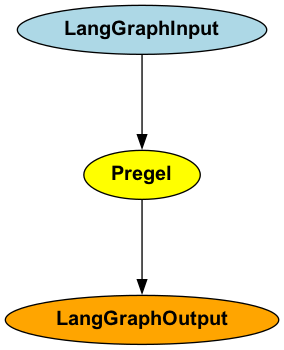

In [81]:
Image(storm.get_graph().draw_png())

In [84]:
async for step in storm.astream(
    {
        "topic": "Развитие российских больших языковых моделей в 2024 году",
    }
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    if END in step:
        results = step

init_research
--  {'topic': 'Развитие российских больших языковых моделей в 2024 году', 'outline': Outline(page_title='Развитие российских больших языковых моделей в 2024 году', sections=[Section(section_title='Введение', description='Общая информация о языковых моделях и их значимости в современном мире.', subsectio
conduct_interviews
--  {'topic': 'Развитие российских больших языковых моделей в 2024 году', 'outline': Outline(page_title='Развитие российских больших языковых моделей в 2024 году', sections=[Section(section_title='Введение', description='Общая информация о языковых моделях и их значимости в современном мире.', subsectio
refine_outline
--  {'topic': 'Развитие российских больших языковых моделей в 2024 году', 'outline': Outline(page_title='Развитие российских больших языковых моделей в 2024 году', sections=[Section(section_title='Введение', description='Общая информация о языковых моделях и их значимости в современном мире, с акцентом 
index_references
--  {'topic': 'Разви

In [85]:
article = results[END]["article"]

## Render the Wiki

Now we can render the final wiki page!

In [86]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

# Развитие российских больших языковых моделей в 2024 году

### Введение

Большие языковые модели (БЯМ) представляют собой одно из наиболее перспективных и быстро развивающихся направлений в современной области искусственного интеллекта (ИИ)[^1]. Эти модели, использующие алгоритмы машинного обучения для обработки и генерации естественного языка, открывают новые горизонты в понимании и взаимодействии с человеческим языком. В контексте России, большие языковые модели начинают играть ключевую роль в различных областях, предоставляя возможности для исследований и разработки инновационных продуктов и услуг.

### Текущее состояние и развитие

В России значительная часть исследований и разработок в области БЯМ приходится на ведущие компании и университеты. В последние годы было запущено несколько значимых проектов, направленных на создание и улучшение больших языковых моделей для русского языка, таких как ruBERT, ruRoBERTa, ruGPT-3, ruT5 и FRED-T5[^2][^3]. Ключевым направлением развития является увеличение масштаба и сложности моделей, с примерами моделей MPT от компании MosaicML, имеющих до 30 млрд. параметров[^2].

### Вызовы и решения

Разработка и внедрение БЯМ в России сталкиваются с техническими ограничениями, этическими соображениями и вопросами защиты данных. В ответ на эти вызовы, российские исследователи и компании разработали ряд решений, включая оптимизацию алгоритмов, использование облачных технологий, создание прозрачных моделей для защиты персональных данных и предотвращение дезинформации[^2][^3][^4].

### Инновации и будущие направления

Россия активно исследует и разрабатывает новые технологии и методы в области БЯМ, с уникальными подходами и решениями. Одним из перспективных направлений является интеграция БЯМ с другими областями ИИ, создание комплексных систем и разработка малых языковых моделей (МЯМ)[^5]. Это обещает новые прорывы в понимании и обработке естественного языка.

### Регулятивные и этические аспекты

В России разработка регулятивных и этических стандартов для БЯМ находится в процессе, включая создание рамок для регулирования использования данных и разработку этических принципов. Основная цель заключается в обеспечении прозрачности, предотвращении дискриминации и соблюдении авторских прав[^4].

### Заключение

Большие языковые модели остаются одним из наиболее перспективных направлений в области ИИ в России. Они используются в академических и коммерческих проектах, способствуя развитию цифровой экономики. В будущем ожидается, что БЯМ будут продолжать играть значимую роль в развитии технологий ИИ, открывая новые горизонты для исследований и инноваций.

### Ссылки

[^1]: https://anns.ru/articles/news/2023/07/25/5_podhodov_k_otsenke_bolshih_jazikovih_modeley
[^2]: https://www.itweek.ru/foss/article/detail.php?ID=228407
[^3]: https://deepai.org/publication/a-family-of-pretrained-transformer-language-models-for-russian
[^4]: https://russiancouncil.ru/analytics-and-comments/analytics/tak-li-strashen-chatgpt-i-analogichnye-emu-bolshie-yazykovye-modeli/
[^5]: https://aimagazine.com/articles/2024-what-comes-next-for-ai-and-large-language-models